**TODO:**

In [1]:
#Library import statements

from skidl.pyspice import *
#can you say cheeky 
import PySpice as pspice
#becouse it's written by a kiwi you know
import lcapy as kiwi

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import YouTubeVideo, display

import traceback

In [2]:
#notebook specific loading control statements 
%matplotlib inline
#tool to log notebook internals
#https://github.com/jrjohansson/version_information
%load_ext version_information
%version_information skidl, PySpice,lcapy, sympy, numpy, matplotlib, pandas, scipy

Software,Version
Python,3.7.6 64bit [GCC 7.3.0]
IPython,7.12.0
OS,Linux 4.19.104 microsoft standard x86_64 with debian bullseye sid
skidl,0.0.31.dev0
PySpice,1.4.3
lcapy,0.70
sympy,1.6.2
numpy,1.18.1
matplotlib,3.3.0
pandas,1.1.4


In [3]:
from DC_1_Codes import dc_ease

# Thevenin’s DC Equivalent Circuit

Thevenin's Theorem (at DC), states that looking into any open port (two terminals sharing that same current) of a circuit that said open port, in the context of linear circuits. will appear as nothing more than a voltage source in series with a resistor. Where said voltage source is called the equivalent Thevenin voltage source that represents the summation of all voltages delivered to the open port. And the resistance in series of the Thevenin voltage source, the Thevenin resistance, is the resistance if all independent sources in our black box when removed. The brilliant thing about the Thevenin voltage and resistance is that the Thevenin Voltage is the open-circuit voltage and Thevenin resistance, via Nortons Theorem (the current dual to Thevenin theorem) is the ratio of the open-circuit voltage to short circuit current. Thus, giving us the hint to find the two equivalence via SPICE with ease

$$ V_{th}=V_{oc}$$
$$ R_{th}=\dfrac{V_{oc}}{I_{sc}}$$

We can create an open circuit in SPICE in three ways. 
1. leave a port open, it works but is not a good idea due to stability issues that can occur 
2. fill in an open port with an exceptionally large resistor, if you need an open port this is the way to do it and not introduce stability issue 
3. An ideal current source has an infinite internal resistance even with zero current. This is why a dead battery creates an open,

So if we say then the Thevenin resistance is  
$$ R_{th}=\dfrac{\Delta V}{ \Delta I}$$
than  the Thevenin resistance may be found via the slop. So that the voltage at the port of the Thevenin equivalent circuit with a load is given by 
$$V_{p}=R_{th}I_{p}+V_{th}$$ 
And thus, we hook up a current source to the open port under test and sweep the current source to zero to find the Thevenin equivalency via linear regression.

You may be asking yourself why we didn't just use the spice Transfer function (.tf) to find the Thevenin equivalent circuit. While we can use .tf however, .tf really comes from two-port circuit representation that we will be deal with in AC circuits extensively. But without going down that rabbit hole now. One would have to use .tf for every independent source to the open port and then convert the gain from the source to figure out the Thevenin voltage equivalent looking into the port and apply superposition for each independent source. So yeah .tf has its usage as we will see but for finding the Thevenin and Norton circuit it's not practical.

When applying the Thevenin theorem to find the DC equivalent circuit there are in general three cases given the mixture of dependent and independent sources in the circuit that is being reduced. But for our sake with SPICE, we don't care since we will always apply a 1A test current source. If the reader wishes to see how to analytically solve these three cases it is recommended to review the YT video from ALL ABOUT ELECTRONICS ["Thevenin's Theorem Explained (With examples of Independent and Dependent Sources)"](https://youtu.be/8udwPc5pCoA) where are test example for using SPICE are sourced.

## Case 1: All independent source from "Thevenin's Theorem Explained ..." @~4:08 min

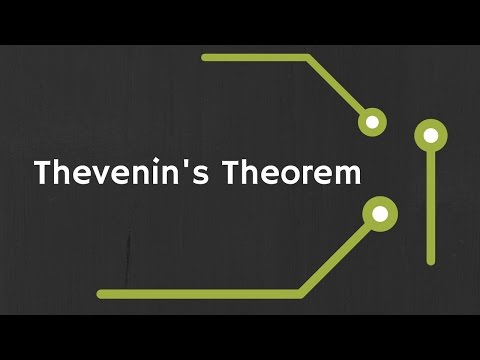

In [4]:
YouTubeVideo('8udwPc5pCoA', width=500, height=400, start=248)

### There is a mistake in the calculation of V_th in case 1.
When calculating the voltage above it was show that the node voltage could be found by using KVL around the loop to find the loop current. But then that current is used to find the voltage at node A via a naive use of the voltage drop around the loop coming from the 10V source on the left through the 10 Ohm resistor on the left giving an incorrect result of 5V. This is due to the fact there are two sources in the loop and thus there is also a superimposed voltage cumming from the right 20V source and right resistor to node A. When attempting to find the voltage at a node it is preferable to use KCL at that node. Thus the correct answer for the Thevenin voltage with respect to node A (treating node B as ground) is given by

$$\dfrac{A-10}{10} +\dfrac{A-20}{10}=0$$
$$\dfrac{2A-30}{10}=0$$
$$A=\dfrac{30}{2}=15[V]=V_{th}$$


### Finding the Theivine Equivlint "Manually"
The following shows how we go about exploring a test setup before consulting the following to a wrap-up tool that we can deploy from a dozen or so lines of code to just two. We will use the already created tool from section adlkfakldjfkj so were not doing a DC sweep from scratch

In [5]:
#create the test circuit from case 1 of ALL ABOUT ELECTRONICS Thevenin YT Video
reset()
#create nets, since the example has named nets for the ports under test we will
#name the nets the same at those two nodes
net_1=Net('N1'); net_A=Net('A'); net_2=Net('N2'); net_B=Net('B')

#create the 10-volt independent source on the left and connect it
vs10=V(ref='10', dc_value=10@u_V); vs10['p', 'n']+=net_1, net_B

#creat the left 10ohm resistor on the left side of the T network
rleft=R(ref='left', value=10@u_Ohm); rleft[1, 2]+=net_1, net_A

# were removing the center 40Ohm resistor since this is our LOAD resistor
#but will keep the statement here in comments, because why not
#rcenter=R(ref='center', value=40@u_Ohm); rcenter[1, 2]+=net_A, net_B

#create the right 10ohm resistor on the right side of the T network
rright=R(ref='right', value=10@u_Ohm); rright[1, 2]+=net_A, net_2

#create the 20-volt independent source on the right and connect it
vs20=V(ref='20', dc_value=20@u_V); vs20['p', 'n']+=net_2, net_B

#ne need a ground for SPICE so why not just force net B to ground
net_B+=gnd

#port is at nodes A,B


circ=generate_netlist()
print(circ)


.title 
V10 N1 0 10V
V20 N2 0 20V
Rleft N1 A 10Ohm
Rright A N2 10Ohm




No errors or warnings found during netlist generation.



In [6]:
sim=circ.simulator()
dc_vals=sim.operating_point()
dc_vals[node(net_A)]

WaveForm a [15.]@V

We add our test current source (`Ithev`) at the open port with a 1A test amount and regenerate the circuit's netlist. Since reset has not been appended to the existing global circuit that was created in the cell above.

In [7]:
ithev=I(ref='Ithev', dc_value=1@u_A); ithev['p', 'n']+=net_B, net_A
circ=generate_netlist()
print(circ)

.title 
V10 N1 0 10V
V20 N2 0 20V
Ithev 0 A 1A
Rleft N1 A 10Ohm
Rright A N2 10Ohm




No errors or warnings found during netlist generation.



Now we use our `dc_ease` tool to conduct a sweep of `Ithev` from 0A to 1A by .1A to which gives use the $V_{oc}$ that we need along with a simple test current for any dependent source and a step size that produces enough data point to perform a clear 1d regression to find $R_{th}$

In [8]:
basic_theiv_test=dc_ease(circ)
basic_theiv_test.sweep_DF.at['Ithev']=[0, 1, .1]
basic_theiv_test.clean_table()
basic_theiv_test.sweep_DF

,Start,Stop,Step
Element,,,
Ithev,0,1,0.1


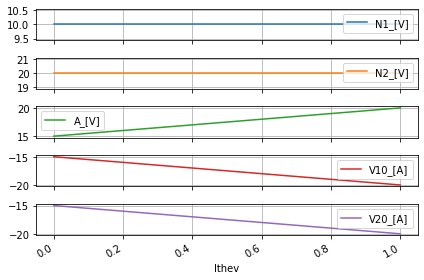

In [9]:
basic_theiv_test.do_dc_sim('Ithev')
basic_theiv_test.quick_plot()

So now taking out the results of the DC sweep which are stored in a pandas Dataframe we can easily filter the data and create a basic plot in 2 lines of code.

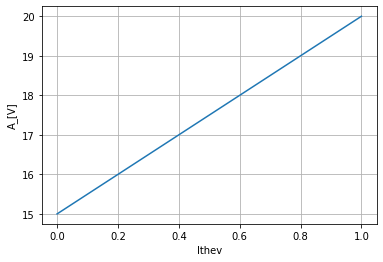

In [10]:
thev_data=basic_theiv_test.dc_resultsNB_DF['A_[V]']
thev_data.plot(ylabel='A_[V]', grid=True);

From here we use Numpy's  [`polyfit`](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html) tool to perform our 1D regression of the data that will yield the slope, intercept which is our $R_{th}$ and $V_{th}$ equivalently

In [11]:
rthev, vthev=np.polyfit(thev_data.index, thev_data.values, 1)
rthev, vthev

### Creating a packaged tool find Theivine Equivlint automatically
Since one of the goals of this book is to spare on Analog Design Verification and to do so Analog design verification needs to have smart test suites. So let then let's take what we have just done and wrap it up into a single convenient tool that does all the work in three lines of code when we're done.

The process of doing this again is called abstraction, and to do abstraction we review what we did manually and then break down that process into automated usage. 
1. We created a circuit with an open port that is our DUT 
2. We added a 1A current source to said open port and generated the netlist to simulate against
3. We performed a DC sweep of the added current source to zero 
4. We reduced that data from the sweep to just what was need to find $V_{th}$ and $R_{th}$
5. We then feed the reduced data to `ployfit` to get $V_{th}$ and $R_{th}$
6. And this wasn't needed, but it nice to have, we create a graph of our data

So then our abstraction response should be: 
1. This is creating the data, and since at the moment we can not remove elements from a SKiDl circuit we can not abstract this. But we have to tell the user to have an open port and tell our tool what nets make up the open port 
2. Since we are restricting this to a linear circuit undergoing a .dc sim we can always use a 1A source. Further, since this is for 1 port DUT that the user will always have prepared and SKiDl makes it trivial to this, yeah this is going to be automated 
3. We will reuse the machiner of dc_ease , more on this in a bit, but since we are only sweeping this one source, yeah easy automation 
4. SKiDl makes finding things the nodes and elements at our DUT's test Port trivial, so yeah easy automation 
5. we just need to wrap this 
6. We don't have to add this, but it's always nicer to someone, even yourself in the future, to add nice built-in data displays

So automating this is going to be straight forward, and to make it more straight forward we are going to use OOP to create our new tool as an inherited extension of the `dc_ease` which means we don't have to invoke `dc_ease` inside our new tool and any changes made to `dc_ease` propagate down the so-called inheritance stack. That doesn't mean that inheritance guarantees that our new tool won't break if changes are made to `dc_ease`. Again this is not a book on Python programming that goes over the details of OOP and inheritance. But suffice to say it's standard code development practice, and thus we should use it here as well.

In [12]:
#%%writefile -a DC_1_Codes.py
#chapter 1 section 5 Thevenin class
# class that is a automated testsuite for finding the 
# DC Thevenin voltage and resistince of a port

class Thevenin(dc_ease):
    """
    Tool for finding the DC Thevenin equivalent voltage and resistance of a one port
    linear circuit with an open test port. The DUT must contain all linear elements.
    This class inheritance from the class `dc_ease` which is a tool to wrap and conduct .dc
    SPICE simulation with SkiDl and pyspice
    """
    
    def __init__(self, port_pos, port_neg):
        """
        A new instantiation unique to this class but utilizes `dc_ease` internally.
        Will add a 1A current source to the open port and will then generate the netlist
        to simulate against within this class
        
        Args:
            port_pos (SkiDl net): A SKiDl net that makes up the positive side of 
                the DUT's open port to test
            
            port_neg (SkiDl net): A SKiDl net that makes up the negative side of 
                the DUT's open port to test
        
        Returns:
            adds a 1A test source: `self.ithev` and creates that netlist to test:
            `self.circ_netlist_obj`
        
        TODO:
            -add assertions so that only a SKiDl net obj can only be passed in
            -add an assertion to see if the port is truly open
        """
        
        #add a current source to get Thevenin at port
        self.ithev=I(ref='Ithev', dc_value=1@u_A)
        self.ithev['n', 'p']+=port_pos, port_neg
        self.ithev_ref=self.ithev.ref
        
       
        #call generate netlist to create circ like we would if using `dc_ease`
        #by its self and simultaneously pass it into while invoking `dc_ease`'s
        # own instatation method
        super().__init__(generate_netlist())
        #print out the resulting circuit for debugging
        print('circuit and Thevenin finding Isource')
        print(self.circ_netlist_obj)
    
    
    def find_thev(self):
        """
        method to conduct the dc sweep of `self.ithev` automatically and find the 
        resulting Thevenin voltage and resistance
        
        Args: NONE
        
        Returns:
            see `dc_ease`'s `record_dc_nodebranch` for a full list of returns. But specifically will
            return `self.thevenin_sweep_data` which is the pandas' object with the
            returned sweep data with only the necessary data for finding the Vth and Rth.
            `self.rthev` and `self.vthev` which are Vth and Rth as floats respectively and
            `self.thev_results` which is a panda dataframe presenting Vth and Rth in a table
        
        TODO:
            
        """
        #set the sweep table
        self.sweep_DF.at[self.ithev_ref]=[0, 1, 0.1]
        self.clean_table()
        
        #do the sweep
        self.do_dc_sim(self.ithev_ref)
        #get the results 
        self.record_dc_nodebranch(self.ithev_ref)
        
        #reduce the data
        self.thevenin_sweep_data=self.dc_resultsNB_DF[node(self.ithev['n'])+'_[V]']
        
        #perform the 1d polyfit
        self.rthev, self.vthev=np.polyfit(self.thevenin_sweep_data.index, self.thevenin_sweep_data.values, 1)
        
        #make a pandas dataframe table, because it's the nice thing to do
        self.thev_results=pd.DataFrame(index=['Rthev', 'Vthev'], columns=['Values', 'Units'])
        self.thev_results['Units']=['[Ohm]', '[V]']
        self.thev_results['Values']=[self.rthev, self.vthev]
        
        
    def display_thev(self):
        """
        Auxiliary function to plot our Thevenin findings, useful for presentions
        and debugging
        
        Args: None
        
        Returns:
            Creates a plot and with a table to the side with the Thevenin equivalent finding
            with a table to the side summering our finding
        
        TODO:
            - add a check to make sure self.find_thev has been done
            
        """
        #create the plot "canvas"
        fig, axis=plt.subplots(nrows=1, ncols=1)
        
        #make a line plot on canvas of sweep data 
        self.thevenin_sweep_data.plot(grid=True, 
        xlabel=self.ithev_ref+'_[A]', ylabel=node(self.ithev['n'])+'_[V]', 
                                     ax=axis)
        
        #create "annotation" to hold self.thev_results in and to display next to the plot
        Anotation=['Theven Port Results:\n']
        for row in self.thev_results.itertuples():
            Anotation.append('   '+f'{row.Index}: {row.Values:.3f} {row.Units}' +'\n')
        
        Anotation=''.join(Anotation)

        fig.text(1.1,.4, Anotation, fontsize=14, transform=fig.transFigure)
        fig.suptitle('Thevin current sweep results')


In [13]:
#Reset and recreate the circuit above to use to test our new `Thevenin` finding tool against
#create the test circuit from case 1 of ALL ABOUT ELECTRONICS Thevenin YT Video
reset()
#create nets, since the example has named nets for the ports under test we will
#name the nets the same at those two nodes
net_1=Net('N1'); net_A=Net('A'); net_2=Net('N2'); net_B=Net('B')

#create the 10-volt independent source on the left and connect it
vs10=V(ref='10', dc_value=10@u_V); vs10['p', 'n']+=net_1, net_B

#creat the left 10ohm resistor on the left side of the T network
rleft=R(ref='left', value=10@u_Ohm); rleft[1, 2]+=net_1, net_A

# We're removing the center 40Ohm resistor since this is our LOAD resistor
#but will keep the statement here in comments, because why not
#rcenter=R(ref='center', value=40@u_Ohm); rcenter[1, 2]+=net_A, net_B

#create the right 10ohm resistor on the right side of the T network
rright=R(ref='right', value=10@u_Ohm); rright[1, 2]+=net_A, net_2

#create the 20-volt independent source on the right and connect it
vs20=V(ref='20', dc_value=20@u_V); vs20['p', 'n']+=net_2, net_B

#ne need a ground for SPICE so why not just force net B to ground
net_B+=gnd

#port is at nodes A,B


circ=generate_netlist()
print(circ)


.title 
V10 N1 0 10V
V20 N2 0 20V
Rleft N1 A 10Ohm
Rright A N2 10Ohm




No errors or warnings found during netlist generation.



So now we put our new tool `Thevenin` to work in finding the Thevenin equivalent circuits

In [14]:
#create an instance of Thevenin and feed it the open port from the test circuit
test=Thevenin(net_A, net_B)

circuit and Thevenin finding Isource
.title 
V10 N1 0 10V
V20 N2 0 20V
Ithev 0 A 1A
Rleft N1 A 10Ohm
Rright A N2 10Ohm




No errors or warnings found during netlist generation.



In [15]:
#run the method to get the Thevenin values and display the Thevenin data 
# to verify functionality
test.find_thev()
test.thevenin_sweep_data

Ithev
0.0    15.0
0.1    15.5
0.2    16.0
0.3    16.5
0.4    17.0
0.5    17.5
0.6    18.0
0.7    18.5
0.8    19.0
0.9    19.5
1.0    20.0
Name: A_[V], dtype: float64

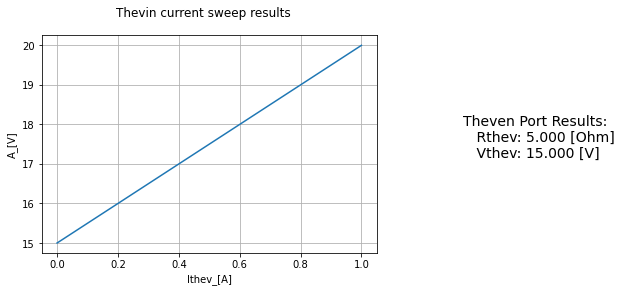

In [16]:
# and finally to the display utility out for a test drive
test.display_thev()

And thus we have reproduced what we did "manually" with our new tool Thevenin

## Case 2: Mixture of independent and dependent source from "Thevenin's Theorem Explained ..." @~6:59 min

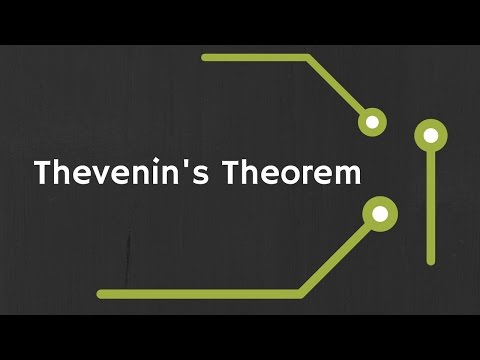

In [17]:
YouTubeVideo('8udwPc5pCoA', width=500, height=400, start=419)


No errors or warnings found during netlist generation.



circuit and Thevenin finding Isource
.title 
E1 N2 A A 0 3
Ithev 0 A 1A
V1 N1 0 5V
Rleft N2 0 2kOhm
Rright A 0 1kOhm
Rvs N1 N2 2kOhm



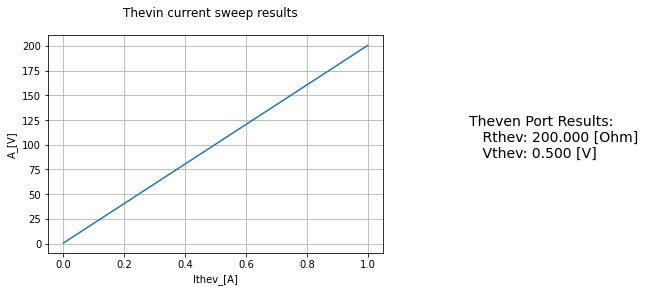

In [18]:
#Cirucit from case 2
reset()
net_1=Net('N1');net_2=Net('N2');net_A=Net('A'); net_B=Net('B')

vs=V(dc_value=5@u_V); vs['p', 'n']+=net_1, net_B
rvs=R(ref='vs', value=2@u_kOhm); rvs[1, 2]+=net_1, net_2
rleft=R(ref='left', value=2@u_kOhm); rleft[1, 2]+=net_2, net_B

#create the voltage-controlled voltage source
vcvs=E(gain=3)
#vcvs inputs; outputs
vcvs['ip', 'in']+=net_A, net_B; vcvs['op', 'on']+=net_2, net_A

rright=R(ref='right', value=1@u_kOhm); rright[1, 2]+=net_A, net_B

#force net_B to be ground
net_B+=gnd

#port is at nodes A,B

#add our test suite ` Thevenin ` and let it solve and show the results
ThevTest=Thevenin(net_A, net_B)
ThevTest.find_thev()
ThevTest.display_thev()

## Case 3: All dependent source from "Thevenin's Theorem Explained ..." @~11:51 min

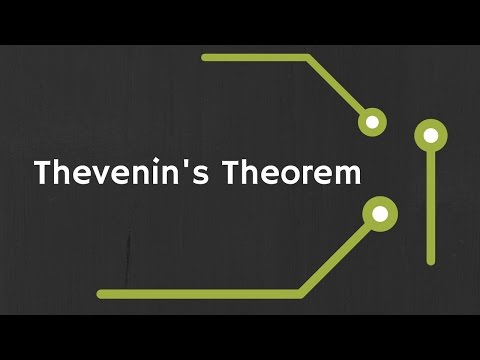

In [19]:
YouTubeVideo('8udwPc5pCoA', width=500, height=400, start=711)


1 warnings found during netlist generation.
0 errors found during netlist generation.



circuit and Thevenin finding Isource
.title 
H1 N1 0 Vamm
Ithev 0 A 1A
Vamm Ap A 0V
Rcs N1 Ap 6Ohm
Rright Ap 0 4Ohm



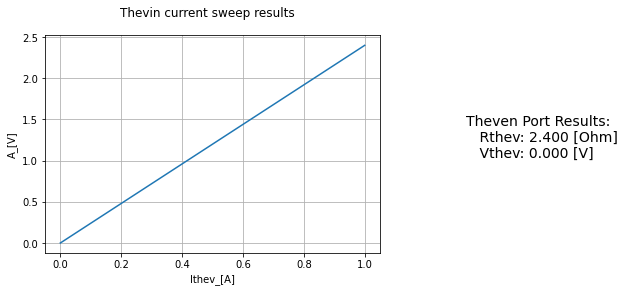

In [20]:
#Cirucit from case 3
reset()
net_1=Net('N1');net_Aprime=Net('Ap'); net_A=Net('A'); net_B=Net('B')

rcs=R(ref='cs', value=6@u_Ohm); rcs[1, 2]+=net_1, net_Aprime
rright=R(ref='right', value=4@u_Ohm); rright[1, 2]+=net_Aprime, net_B

vamm=V(ref='amm', dc_value=0@u_V); vamm['p', 'n']+=net_Aprime, net_A

#create the voltage-controlled current source, let it know the current monter, and connect
vccs=H(gain=3, control=vamm.ref_prefix+vamm.ref); vccs['p', 'n']+=net_1, net_B


#force net b to ground
net_B+=gnd

#port is at nodes A,B

#let the Thevenin find test sweep rip
ThevTest=Thevenin(net_A, net_B)
ThevTest.find_thev()
ThevTest.display_thev()

# Norton's Theorem

Norton's theorem is just the dual to Thevenin's so that
$$I_N=I_{sc}$$
$$R_{th}=R_{N}=\dfrac{1}{G_N}=\dfrac{V_{oc}}{I_{sc}}$$

And so to measure it with SPICE we just replace a current source at the open port with a Voltage source.
You might wonder why would anyone measure the short circuit current since sorts are typically not a good thing if not outright dangerous. Though to be fair unintentional and or uncontrolled opens are just as dangerous. The reason steams to one of the goals in this book and that is to create testbenchs for SPICE that mimic test setups in the lab. And while measuring the Thevenin in the lab is typically more preferable since we can start from an open circuit using a load then move toward shorting the open and using interpolation to then infer the actual short without having to make a real short. Certain testing, especially with batteries will conduct tests with short circuits. So why not have a Python-SPICE testbench ready to go and proven out before it's needed.


## Example 1: All independent source from "Norton's Theorem Explained ..." @~3:32 min

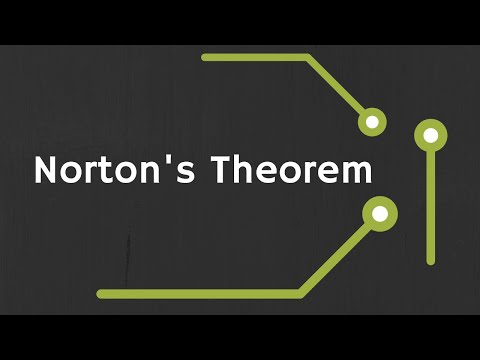

In [21]:
YouTubeVideo('DdLA8rntWEY', width=500, height=400, start=212)

### Finding the Northon Equivlint "Manualy"
So why are we gain going over the manual way when we know we're just going to create a wrapped tool. Cause first of all there is a subtle detail in that when we use a voltage source we can choose to either use the internal current or the current from the ammeter trick. For illustration purposes, we choose to do with the internal one. The second reason is to illustrate the process of abstraction. And that is trying not to rush into it. Build up a suite of test cases to then let the abstraction come.

In [22]:
#cirucit from example 1 of Norton YT
reset()
net_1=Net('N1');net_2=Net('N2');net_A=Net('A'); net_B=Net('B')

cs=I(dc_value=2@u_A); cs['n', 'p']+= net_1, gnd
vs=V(dc_value=12@u_V); vs['p', 'n']+=net_2, gnd

rvs=R(ref='vs', value=4@u_Ohm); rvs[1, 2]+=net_1, net_2
rtop=R(ref='top', value=8@u_Ohm); rtop[1, 2]+=net_1, net_A
rbot=R(ref='bot', value=8@u_Ohm); rbot[1, 2]+=gnd, net_B
rright=R(ref='right', value=5@u_Ohm); rright[1, 2]+=net_A, net_B

#port is at nodes A,B
circ=generate_netlist()
print(circ)

.title 
I1 0 N1 2A
V1 N2 0 12V
Rbot 0 B 8Ohm
Rright A B 5Ohm
Rtop N1 A 8Ohm
Rvs N1 N2 4Ohm




No errors or warnings found during netlist generation.



Add the voltage source at the open port nets and regenerate the netlist

In [23]:
Vnort=V(ref='Vnort', dc_value=1@u_V); Vnort['p', 'n']+=net_A, net_B
circ=generate_netlist()
print(circ)

.title 
I1 0 N1 2A
V1 N2 0 12V
Vnort A B 1V
Rbot 0 B 8Ohm
Rright A B 5Ohm
Rtop N1 A 8Ohm
Rvs N1 N2 4Ohm




No errors or warnings found during netlist generation.



setup the dc sweep of the test voltage source

In [24]:
basic_nort_test=dc_ease(circ)
basic_nort_test.sweep_DF.at['Vnort']=[0, 1, .1]
basic_nort_test.clean_table()
basic_nort_test.sweep_DF

,Start,Stop,Step
Element,,,
Vnort,0,1,0.1


Run the simulation, where we are opting for the internal current for the test voltage source, for no other reason than to contrast with the Thevenin tool that was made above.

In [25]:
basic_nort_test.do_dc_intsim('Vnort')
#not doing a quick plot here because the number columns vs the resolution of 
#subplots does not go well

Unit is None for @rtop[p] power
Unit is None for @v1[p] power
Unit is None for @rbot[p] power
Unit is None for @i1[p] power
Unit is None for @rvs[p] power
Unit is None for @vnort[p] power
Unit is None for @rright[p] power


Since we are only interested in the recorded internal current of the test voltage source we will just grab that one column

In [26]:
#get all the columns that were measured
basic_nort_test.dc_resultsINT_DF.columns

Index(['I1[c]_[A]', 'I1[v]_[V]', 'I1[p]_[W]', 'V1[i]_[A]', 'V1[p]_[W]',
       'Vnort[i]_[A]', 'Vnort[p]_[W]', 'Rbot[i]_[A]', 'Rbot[p]_[W]',
       'Rright[i]_[A]', 'Rright[p]_[W]', 'Rtop[i]_[A]', 'Rtop[p]_[W]',
       'Rvs[i]_[A]', 'Rvs[p]_[W]'],
      dtype='object')

In [27]:
#grap the one columne of data we care about 
nort_data=basic_nort_test.dc_resultsINT_DF['Vnort[i]_[A]']
nort_data

Vnort
0.0   -1.000
0.1   -0.975
0.2   -0.950
0.3   -0.925
0.4   -0.900
0.5   -0.875
0.6   -0.850
0.7   -0.825
0.8   -0.800
0.9   -0.775
1.0   -0.750
Name: Vnort[i]_[A], dtype: float64

Do our linear fitting of the data noting that the slop will be the conductance so we need to flip it to get resistance, and don't worry about the sign of the current as long as for this case the resistance is positive. Just recall our discussions thus far about the sign of currents in SPICE.

In [28]:
Cnort, Inort=np.polyfit(basic_nort_test.dc_resultsINT_DF.index, basic_nort_test.dc_resultsINT_DF['Vnort[i]_[A]'], 1)
Rnort=1/Cnort
Cnort, Inort

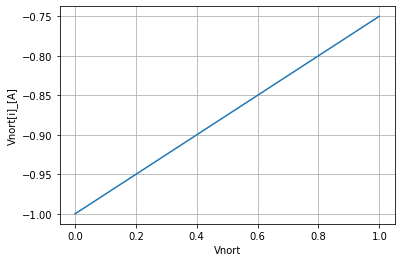

In [29]:
nort_data.plot(ylabel='Vnort[i]_[A]', grid=True);

### Creating a packaged tool find Norton Equivlint automatically
This is fairly self-explanatory if you have read how the Thevenin tool was made. The one thing to note here is that we didn’t do an inheritance from the Thevenin tool. The reason is that the Norton and Thevenin tools are in essence an evolutionary fork from `dc_ease`

In [30]:
#%%writefile -a DC_1_Codes.py
#chapter 1 section 5 Norton class
# class that is a automated testsuite for finding the 
# DC Norton current and resistince of a port

class Norton(dc_ease):
    """
    Tool for finding the DC Norton equivalent current and resistance of a one port
    linear circuit with an open test port. The DUT must contain all linear elements.
    This class inheritance from the class `dc_ease` which is a tool to wrap and conduct .dc
    SPICE simulation with SkiDl and pyspice
    """
    
    def __init__(self, port_pos, port_neg):
        """
        A new instantiation unique to this class but utilizes `dc_ease` internally.
        Will add a 1V voltage source to the open port and will then generate the netlist
        to simulate against within this class
        
        Args:
            port_pos (SkiDl net): A SKiDl net that makes up the positive side of 
                the DUT's open port to test
            
            port_neg (SkiDl net): A SKiDl net that makes up the negative side of 
                the DUT's open port to test
        
        Returns:
            adds a 1V test source: `self.vnort` and creates that netlist to test:
            `self.circ_netlist_obj`
        
        TODO:
            -add assertions to so that only a SKiDl net obj can only be passed in
            -add an assertion to see if the port is truly open
        """
        
        #add voltage source to get Norton at port
        self.vnort=V(ref='Vnort', dc_value=1@u_V)
        self.vnort['p', 'n']+=port_pos, port_neg
        self.vnort_ref=self.vnort.ref
        
       
        #call generate netlist to create circ like we would if using `dc_ease`
        #by its self and simultaneously pass it into while invoking `dc_ease`'s
        # own instatation method
        super().__init__(generate_netlist())
        #print out the resulting circuit for debugging
        print('circuit and Thevenin finding Isource')
        print(self.circ_netlist_obj)
    
    
    def find_nort(self):
        """
        method to conduct the dc sweep of `self.ithev` automatically and find the 
        resulting Norton current and resistance
        
        Args: NONE
        
        Returns:
            see `dc_ease`'s `record_dc_internals` for a full list of returns. But specifically will
            return `self.norton_sweep_data` which is the pandas' object with the
            returned sweep data with only the necessary data for finding the Vth and Rth.
            `self.rnort` (`self.gnort`) and `self.inort` which are In and Rn as floats respectively and
            `self.nort_results` which is a pandas dataframe presenting In and Rn in a table
        
        TODO:
            
        """
        #set the sweep table
        self.sweep_DF.at[self.vnort_ref]=[0, 1, 0.1]
        self.clean_table()
        
        #do the sweep
        self.do_dc_intsim(self.vnort_ref)
        #get the results 
        self.record_dc_internals(self.vnort_ref)
        
        #reduce the data
        self.norton_sweep_data=self.dc_resultsINT_DF[self.vnort_ref+'[i]_[A]']
        
        #perform the 1d polyfit
        self.gnort, self.inort=np.polyfit(self.norton_sweep_data.index, self.norton_sweep_data.values, 1)
        #flip from conductance to resistance
        self.rnort=1/self.gnort
        
        #make a pandas dataframe table, because it's the nice thing to do
        self.nort_results=pd.DataFrame(index=['Rnort', 'Inort'], columns=['Values', 'Units'])
        self.nort_results['Units']=['[Ohm]', '[A]']
        self.nort_results['Values']=[self.rnort, self.inort]
        
        
    def display_nort(self):
        """
        Auxiliary function to plot our Norton findings, useful for presentions
        and debugging
        
        Args: None
        
        Returns:
            Creates a plot and with a table to the side with the Norton equivalent finding
            with a table to the side summering our finding
        
        TODO:
            - add a check to make sure self.find_nort  has been done
            
        """
        #create the plot "canvas"
        fig, axis=plt.subplots(nrows=1, ncols=1)
        
        #make a line plot on canvas of sweep data 
        self.norton_sweep_data.plot(grid=True, 
        xlabel=self.vnort_ref+'_[V]', ylabel=self.vnort_ref+'[i]_[A]', 
                                     ax=axis)
        
        #create "annotation" to hold self.nort_results in and to display next to the plot
        Anotation=['Norton Port Results:\n']
        for row in self.nort_results.itertuples():
            Anotation.append('   '+f'{row.Index}: {row.Values:.3f} {row.Units}' +'\n')
        
        Anotation=''.join(Anotation)

        fig.text(1.1,.4, Anotation, fontsize=14, transform=fig.transFigure)
        fig.suptitle('Norten voltage sweep results')



No errors or warnings found during netlist generation.

Unit is None for @rtop[p] power
Unit is None for @v1[p] power
Unit is None for @rbot[p] power
Unit is None for @i1[p] power
Unit is None for @rvs[p] power
Unit is None for @vnort[p] power
Unit is None for @rright[p] power


circuit and Thevenin finding Isource
.title 
I1 0 N1 2A
V1 N2 0 12V
Vnort A B 1V
Rbot 0 B 8Ohm
Rright A B 5Ohm
Rtop N1 A 8Ohm
Rvs N1 N2 4Ohm



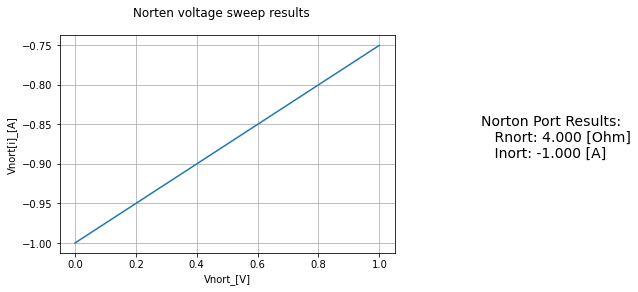

In [31]:
#resuse of example 1 to test `Norton`
reset()
net_1=Net('N1');net_2=Net('N2');net_A=Net('A'); net_B=Net('B')

cs=I(dc_value=2@u_A); cs['n', 'p']+= net_1, gnd
vs=V(dc_value=12@u_V); vs['p', 'n']+=net_2, gnd

rvs=R(ref='vs', value=4@u_Ohm); rvs[1, 2]+=net_1, net_2
rtop=R(ref='top', value=8@u_Ohm); rtop[1, 2]+=net_1, net_A
rbot=R(ref='bot', value=8@u_Ohm); rbot[1, 2]+=gnd, net_B
rright=R(ref='right', value=5@u_Ohm); rright[1, 2]+=net_A, net_B

#port is at nodes A,B

# instantiate Norton feeding it the port terminal nets
NortTest=Norton(net_A, net_B)
#Have it find Norton values
NortTest.find_nort()
#fancy display results
NortTest.display_nort()

## Example 2: Mixture of independent and dependent source from "Norton's Theorem Explained ..." @~7:03 min

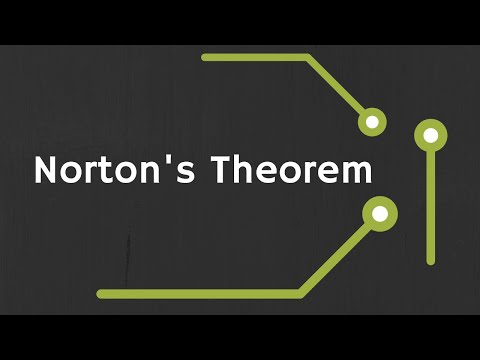

In [32]:
YouTubeVideo('DdLA8rntWEY', width=500, height=400, start=423)


1 warnings found during netlist generation.
0 errors found during netlist generation.

Unit is None for @v1[p] power
Unit is None for @f1[p] power
Unit is None for @rleft[p] power
Unit is None for @rcenter[p] power
Unit is None for @vnort[p] power
Unit is None for @vix[p] power


circuit and Thevenin finding Isource
.title 
F1 N1 A Vix 2
V1 N1 0 10V
Vnort A 0 1V
Rcenter N1 A 5Ohm
Vix N1 N1prime 0V
Rleft N1prime 0 4Ohm



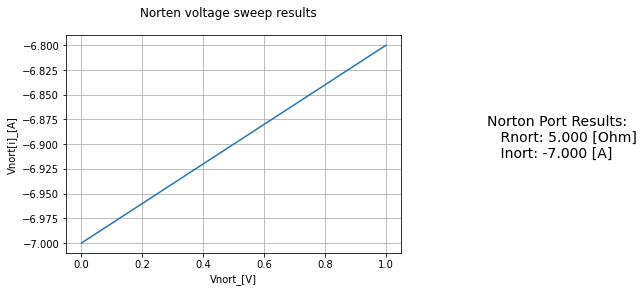

In [33]:
#Cirucit from example 3
reset()
#addedd a 'prime' node to attache the current ammeter 'ix' for the cccs
net_1=Net('N1'); net_1prime=Net('N1prime'); net_A=Net('A'); net_B=Net('B')

rleft=R(ref='left', value=4@u_Ohm); rleft[1, 2]+=net_1prime, net_B
vs=V(dc_value=10@u_V); vs['p', 'n']+=net_1, net_B
rcenter=R(ref='center', value=5@u_Ohm); rcenter[1, 2]+=net_1, net_A

#current ammeter 'ix' for the cccs
vix=V(ref='ix', dc_value=0@u_V); vix['n', 'p']+=net_1prime, net_1

#create the cccs and give it the control
cccs=F(gain=2, control=vix.ref_prefix+vix.ref)
cccs['p', 'n']+=net_1, net_A

#force net_B to ground
net_B+=gnd

NortTest=Norton(net_A, net_B)
NortTest.find_nort()
NortTest.display_nort()

## Example 3: All dependent source from "Norton's Theorem Explained ..." @~11:27 min

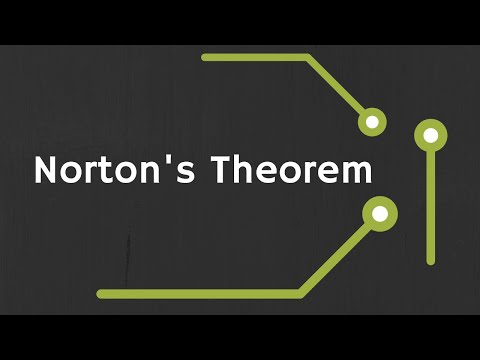

In [34]:
YouTubeVideo('DdLA8rntWEY', width=500, height=400, start=687)


1 warnings found during netlist generation.
0 errors found during netlist generation.

Unit is None for @rleft[p] power
Unit is None for @rcenter[p] power
Unit is None for @vnort[p] power
Unit is None for @rright[p] power
Unit is None for @g1[p] power


circuit and Thevenin finding Isource
.title 
G1 N1 0 A 0 0.1
Vnort A 0 1V
Rcenter A N1 50Ohm
Rleft A 0 100Ohm
Rright N1 0 200Ohm



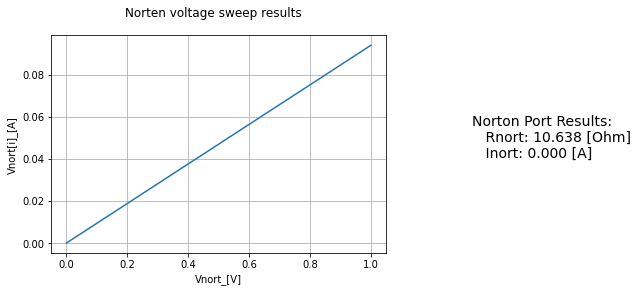

In [35]:
#Cirucit from exsample 3
reset()
net_1=Net('N1'); net_A=Net('A'); net_B=Net('B')

rleft=R(ref='left', value=100@u_Ohm); rleft[1, 2]+=net_A, net_B
rcenter=R(ref='center', value=50@u_Ohm); rcenter[1, 2]+=net_A, net_1
rright=R(ref='right', value=200@u_Ohm); rright[1, 2]+=net_1, net_B

vccs=G(gain=1/10)
vccs['ip', 'in']+=net_A, net_B; vccs['op', 'on']+=net_1, net_B

net_B+=gnd

#port is at nodes A, B

NortTest=Norton(net_A, net_B)
NortTest.find_nort()
NortTest.display_nort()

## Citations:
[1] ALL ABOUT ELECTRONICS. "Thevenin's Theorem Explained (With examples of Independent and Dependent Sources)," YouTube, Apr 8, 2017. [Video file]. Available: https://youtu.be/8udwPc5pCoA. [Accessed: Nov 30, 2020].


[2] ALL ABOUT ELECTRONICS. "Norton's Theorem Explained (With examples of Independent and Dependent Sources)," YouTube, Feb 1, 2020. [Video file]. Available: https://youtu.be/DdLA8rntWEY. [Accessed: Nov 30, 2020].